# Q-Table Learning

In [1]:
import gym
import numpy as np
import pandas as pd

import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

### Implement Q-Table learning algorithm

In [3]:
# Initialize table with all 0s
Q = np.zeros([env.observation_space.n, env.action_space.n])
# Set learning parameters
lr = 0.8
y = 0.95  # discount factor
num_episodes = 2000
# Create lists to contain total rewards and steps per episode
jList = []
rList = []
for i in range(num_episodes):
    # Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # The Q-Table learning algorithm
    while j < 99:
        j += 1
        # Choose an action by greedily (with noise) picking
        # from the Q-table
        a = np.argmax(
            # Amount of noise added decreases with each episode
            Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i+1))
        )
        # Get new state and reward from environment. env.step(a) returns:
        # next observed state s1, reward for action a in state s, (bool) if agent is done, (dict) info
        s1, r, d, _ = env.step(a)
        # Update Q-table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)

In [4]:
# DataFrame of score and number of steps for each episode
history = pd.DataFrame({'score': rList, 'num_steps': jList})
pd.concat([history.head(10), history.tail(10)])

,num_steps,score
0,4,0.0
1,3,0.0
2,8,0.0
3,13,0.0
4,6,0.0
5,13,0.0
6,8,0.0
7,10,0.0
8,10,0.0
9,9,0.0


In [5]:
print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of successful episodes: 0.5295%


In [6]:
print("Final Q-Table Values:")
print(Q)

Final Q-Table Values:
[[1.30408691e-02 6.69220968e-03 3.27246970e-01 9.80993889e-03]
 [1.37704429e-03 2.28376563e-03 1.63900020e-03 1.50717715e-01]
 [3.19191745e-03 5.64570002e-03 2.69026939e-03 1.05188658e-01]
 [1.75478977e-03 1.84765782e-03 6.77212007e-05 1.32744693e-02]
 [4.71370903e-01 8.50217676e-04 2.13307757e-04 7.70104176e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.45858415e-03 2.82605650e-07 9.10317156e-04 5.18028863e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.77451146e-03 4.57933901e-03 1.02071016e-03 7.17350167e-01]
 [1.73065492e-04 3.90539615e-01 2.70183370e-03 2.64501150e-04]
 [7.35208301e-02 1.30507179e-03 6.82662704e-04 7.94180006e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.91690455e-03 8.23901086e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.62488026e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0

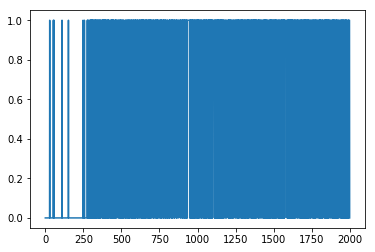

In [7]:
plt.plot(rList)

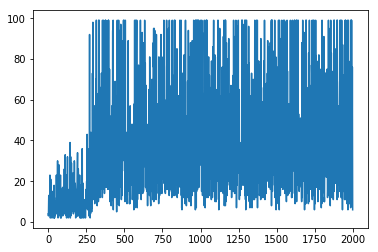

In [8]:
plt.plot(jList)

# Q-Network Learning

In [9]:
# Reload the environment
env = gym.make('FrozenLake-v0')

### Implementing the network itself

In [10]:
tf.reset_default_graph()

In [11]:
# Establish the feed forward part of the network used to choose actions
inputs1 = tf.placeholder(shape = [1, env.observation_space.n], dtype = tf.float32)
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# Obtain the loss by taking the sum of squares difference between the target
# and prediction Q values
nextQ = tf.placeholder(shape = [1, env.action_space.n], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updateModel = trainer.minimize(loss)

### Training the network

In [12]:
init = tf.global_variables_initializer()

# Set learning parameters
y = 0.99  # discount factor
e = 0.1
num_episodes = 2000
# Create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-network
        while j < 99:
            j += 1
            # Choose an action by greedily (with e chance
            # of random action) from the Q-network
            a, allQ = sess.run(
                [predict, Qout], feed_dict = {inputs1: np.identity(env.observation_space.n)[s:s+1]}
            )
            if np.random.rand(1) < e:
                # Take a random action
                a[0] = env.action_space.sample()
            # Get new state and reward from environment
            s1, r, d, _ = env.step(a[0])
            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(
                Qout, feed_dict = {inputs1: np.identity(env.observation_space.n)[s1:s1+1]}
            )
            # Obtain maxQ' and set our target value for chosen action
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r + y*maxQ1
            # Train our network using target and predicted Q values
            _, W1 = sess.run(
                [updateModel, W], feed_dict = {
                    inputs1: np.identity(env.observation_space.n)[s:s+1], nextQ: targetQ
                }
            )
            rAll += r
            s = s1
            if d == True:
                # Reduce chance of random action as we train the model
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of successful episodes: 0.4375%


In [13]:
# DataFrame of score and number of steps each episodes
history = pd.DataFrame({'score': rList, 'num_steps': jList})
pd.concat([history.head(10), history.tail(10)])

,num_steps,score
0,27,0.0
1,12,0.0
2,4,0.0
3,7,0.0
4,3,0.0
5,13,0.0
6,7,0.0
7,5,0.0
8,2,0.0
9,11,0.0


### Some statistics on network performance
We can see that the network begins to consistently reach the goal around the 750 episode mark:

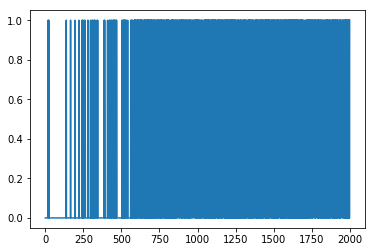

In [14]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance around the 750 mark as well:

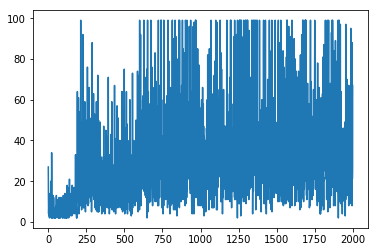

In [15]:
plt.plot(jList)